## inference

In [1]:
# 测试模型正确率
import torch
import torch.nn.functional as F
import model
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision

def evaluate_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())  # Save images for visualization

    acc = correct / total
    print(f"Test Accuracy: {acc * 100:.2f}%")
    return acc, all_images, all_preds, all_labels


In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def visualize_predictions(images, preds, labels, classes, n=16):
    # 将 tensor 转成 [H, W, C]，反标准化
    unnormalize = transforms.Normalize(mean=[-0.4914/0.247, -0.4822/0.243, -0.4465/0.261],
                                       std=[1/0.247, 1/0.243, 1/0.261])
    
    plt.figure(figsize=(12, 8))
    temp = torch.randint(0, len(images)-1, (n,))
    for i in range(n):
        img = unnormalize(images[temp[i]])
        img = img.permute(1, 2, 0).clamp(0, 1).numpy()
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
        color = 'green' if preds[temp[i]] == labels[temp[i]] else 'red'
        title = f"Pred: {classes[preds[temp[i]]]} \nTrue: {classes[labels[temp[i]]]}"
        plt.title(title, color=color, fontsize=10)
    plt.tight_layout()
    plt.show()


In [3]:
def get_misclassified(model, test_loader, classes, device='cuda', max_errors=80):
    model.to(device)
    model.eval()

    wrong_images = []
    wrong_preds = []
    wrong_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # 找出预测错误的索引
            incorrect = preds != labels
            if incorrect.any():
                wrong_images.extend(images[incorrect].cpu())
                wrong_preds.extend(preds[incorrect].cpu().numpy())
                wrong_labels.extend(labels[incorrect].cpu().numpy())

                # 如果已收集足够错误样本就停止
                if len(wrong_images) >= max_errors:
                    break

    return wrong_images[:max_errors], wrong_preds[:max_errors], wrong_labels[:max_errors]


In [12]:
def visualize_misclassified(images, preds, labels, classes, n=8):
    plt.figure(figsize=(12, 8))
    temp = torch.randint(0, len(images)-1, (n,))
    for i in range(n):

        unnormalize = transforms.Normalize(mean=[-0.4914/0.247, -0.4822/0.243, -0.4465/0.261],
                                       std=[1/0.247, 1/0.243, 1/0.261])
        img = unnormalize(images[temp[i]])
        img = img.permute(1, 2, 0).clamp(0, 1).numpy()

        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
        title = f"Pred: {classes[preds[temp[i]]]} \nTrue: {classes[labels[temp[i]]]}"
        plt.title(title, color='red', fontsize=10)
    plt.tight_layout()
    plt.show()

In [5]:
transform_test = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2470, 0.2435, 0.2616])
    ])

In [6]:
model = model.resnet18(pretrained=True, root='saved_models/best_model_config_1.pth')
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
classes = [
    'airplane',   # 飞机
    'automobile', # 汽车
    'bird',       # 鸟
    'cat',        # 猫
    'deer',       # 鹿
    'dog',        # 狗
    'frog',       # 青蛙
    'horse',      # 马
    'ship',       # 船
    'truck'       # 卡车
]

Files already downloaded and verified


In [7]:
# 计算准确率并收集推理结果
acc, all_images, all_preds, all_labels = evaluate_model(model, test_loader, device='cuda')

Test Accuracy: 90.73%


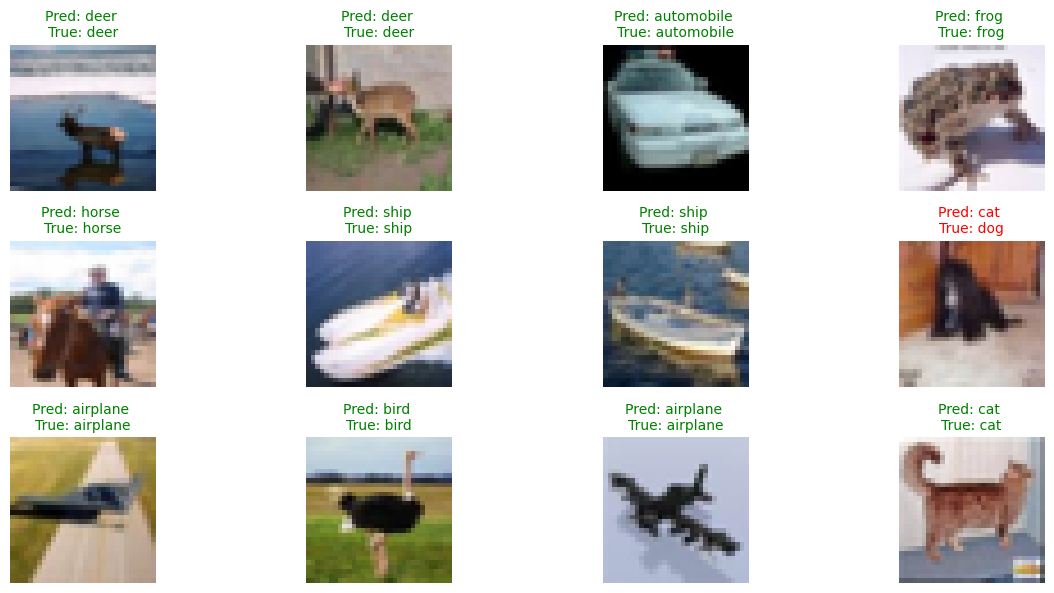

In [13]:
# 可视化前12张图的推理结果
visualize_predictions(all_images, all_preds, all_labels, classes, n=12)

In [9]:
wrong_images, wrong_preds, wrong_labels = get_misclassified(model, test_loader, classes, device='cuda')

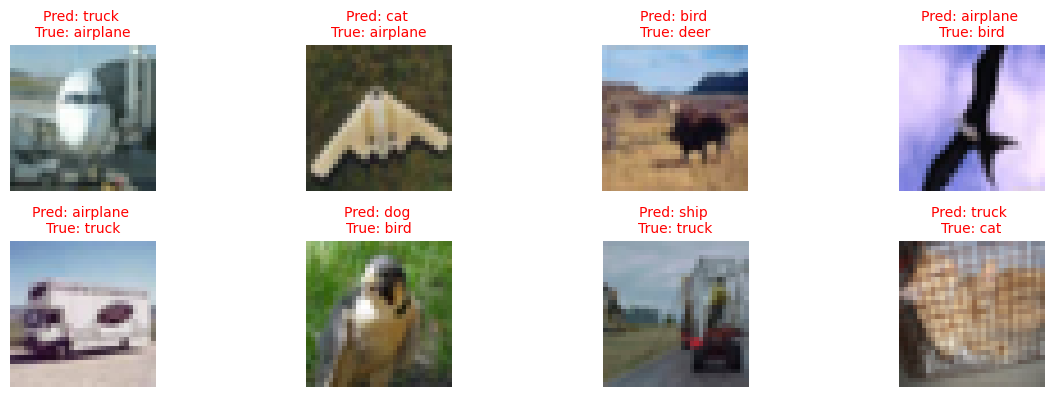

In [14]:
visualize_misclassified(wrong_images, wrong_preds, wrong_labels, classes)